<h1>Churn - Is there a point of no return for customers?</h1>

<br>

<h2><font color='#3498DB'>Contents</font></h2>

<ul>
    <li>Brief</li>
    <li>Data exploration</li>
    <li>Methodology</li>
    <li>Analysis</li>
    <ul>
        <li>Assessing the model</li>
        <li>Predictions</li>
    </ul>
    <li>Insights</li>
</ul>

<br>

<hr>

<br>

<h2><font color='#3498DB'>Brief</font></h2>

<br>

<ul>
    <li><b><code></code></b> - </li>
    <br>
    <li><b><code></code></b> - </li>
    <br>
    <li><b><code></code></b> - </li>
</ul>

<br>

<hr>

<br>

<h2><font color='#3498DB'>Data exploration</font></h2>

<br>

<h3><font color='#90949C'>What data is available?</font></h3>

<p>The <code>churn.csv</code> data contains three fields which can be selected for our analysis. <code>has_churned</code> is the binary indicator of a customer's current status which we will attempt to understand using two potential predictor variables: <code>time_since_first_purchase</code> and <code>time_since_last_purchase</code> (definitions are expanded upon below). The data consists of one row per customer.</p>

<ul>
    <li><b><code>has_churned</code></b> - binary indicator of a customer's churn status according to account activity, e.g. 1 = churned, 0 = retained.</li>
    <li><b><code>time_since_first_purchase</code></b> - also known as "tenure", a measure in years since the customer's first purchase.</li>
    <li><b><code>time_since_last_purchase</code></b> - also known as "recency", a measure in years since the customers last purchase.</li>
</ul>

<br>

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# style
from ipynb.fs.full.Style_Sheet import *
plt.style.use(style_use)
plt.rcParams.update(style_params)
centre_img

In [2]:
# data
file_path = r'churn.csv'
df = pd.read_csv(file_path)

# show
df.head(10)

,has_churned,time_since_first_purchase,time_since_last_purchase
0,0,0.184549,0.149345
1,0,2.456753,1.420000
2,0,0.427614,0.443084
3,0,1.360712,0.334995
4,0,0.107128,0.198026
5,0,1.767170,0.100663
6,0,0.970458,0.073435
7,0,1.479993,1.260000
8,0,1.403923,1.450000
9,0,1.673095,0.354797


<br>

<h3><font color='#90949C'>Recency has a strong relationship with churn</font></h3>

<p>To better understand how the <code>time_since_first_purchase</code> and <code>time_since_last_purchase</code> variables relate to churn, the distributions were analysed using histograms from the <code>seaborn</code> library. This method illustrates the probability of observing particular bandwidth of recency or tenure under a given churn status, e.g. the red area of Fig 1. shows that ~54% of retained customers have made their last purchase within 0.5 years.</p>

<br>

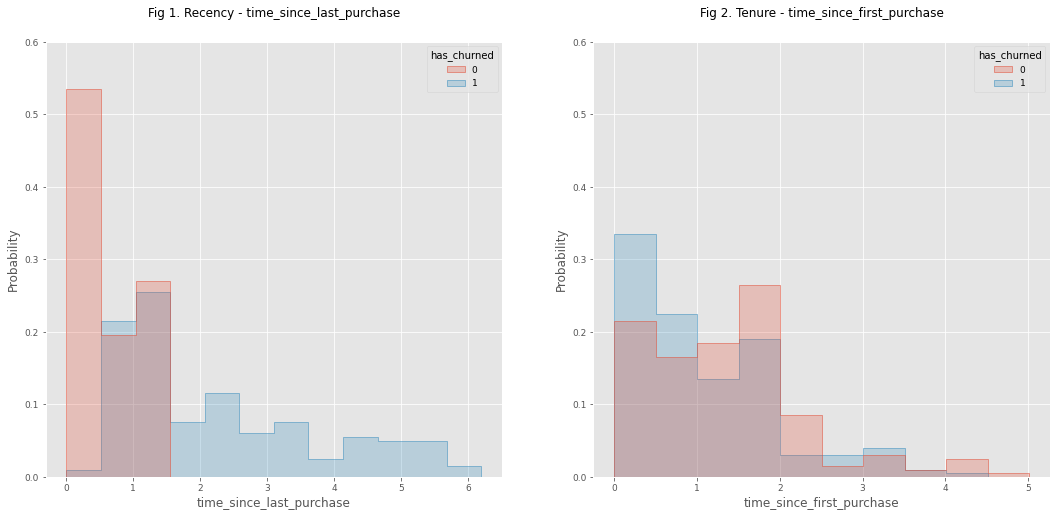

In [3]:
# hist plot
def viz_hist(data, x, kde, ax, title):
    
    # sort bins
    x_min = round(min(data[x]),0)
    x_max = round(max(data[x]),0)
    bins_n = int((x_max - x_min) * 2)
    
    # plot
    sns.histplot(data=data, x=x, kde=kde, ax=ax,
                 hue='has_churned', stat='probability',
                 common_norm=False, element='step', bins=bins_n)
    ax.set_title(title)
    ax.set_ylim(0, 0.6)
    
    # return
    return ax

# dashboard
fig, [ax_1, ax_2] = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

# viz
viz_hist(df, 'time_since_last_purchase', False, ax_1, 'Fig 1. Recency - time_since_last_purchase')
viz_hist(df, 'time_since_first_purchase', False, ax_2, 'Fig 2. Tenure - time_since_first_purchase')

# show
plt.show()

<br>

<p>How <code>time_since_first_purchase</code> relates to churn is unclear: 80% of each population is concentrated within 2 years; the churned population shows a mild decay from 0 - 2 years and the retained population maintains an opposite effect. However, the shared concentration makes it difficult to distinguish how <code>time_since_first_purchase</code> effects churn.</p>

<br>

<p>The <code>time_since_last_purchase</code> distributions reveal several strong trends: 99% of the churned population have not purchased within the last 6 months, 55% have not purchased in the last 1.5 years; in the retained population 100% have purchased within the last 1.5 years, with 54% making the purhase in the last 6 months. These trends coalesce as <i>customers with longer</i> <code>time_since_last_purchase</code> <i>are more likely to have churned</i>. The <code>kde</code> distribution further illustrates how the long tail of recency is a strong indicator of churn.</p>

<br>

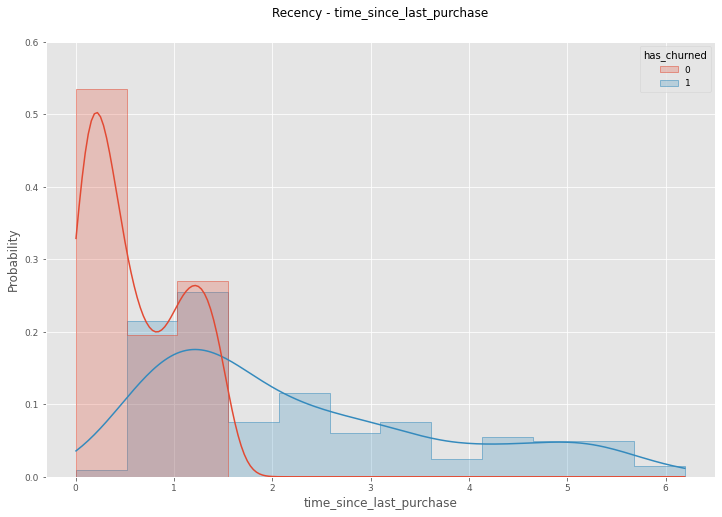

In [4]:
# hist with kde
fig, ax_1 = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
viz_hist(df, 'time_since_last_purchase', True, ax_1, 'Recency - time_since_last_purchase')
plt.show()

<hr>

<br>

<h2><font color='#3498DB'>Methodology</font></h2>

<h3><font color='grey'>Why do we use logistic regression?</font></h3>

<p>Churn is a <code>binary outcome</code>. Our customers either have or have not churned, as indicated by the presence of a 1 or 0. Therefore, our model has to predict this binary outcome based on a customer's recency, i.e. how does a customer's <code>time_since_last_purchase</code> impact whether or not a customer returns a <code>has_churned</code> value of 1? To answer this question, we use <code>logistic regression</code>, a method that differs from linear regression in a straightforward way - instead of building a line of best fit to minimise the residuals, we fit a line to maximise the likelihood (<code>maximum_likelihood</code>) of observing a True outcome. Good explanatory variables will produce an "S-curve".</p>

<br>

<h3><font color='grey'>Using <code>statsmodels</code> to build a logistic regression function</font></h3>

<p>We use the <code>statsmodel</code> package to build logistic regression. This is the preferred package for extracting insights from historical data which can be used to help make decisions (alternatively, <code>scikit-learn</code> is available for logistic regression exercises when optimising for machine learnning).</p>

<br>

In [5]:
from statsmodels.formula.api import logit
from statsmodels.graphics.mosaicplot import mosaic

# log reg function
def reg_log(y, x, data):
    
    # variables
    mdl_v = f'{y} ~ {x}'
    
    # model
    mdl = logit(mdl_v, data=data).fit(disp=0)
    
    # params
    mdl_params = mdl.params
    mdl_intercept = mdl_params[0]
    mdl_slope = mdl_params[1]
    mdl_eq = f'{y} = {mdl_intercept} + {mdl_slope} * {x}'
    
    # predictions
    data['mdl_prediction'] = mdl.predict(data[x])
    data['mdl_prediction_outcome'] = np.round(mdl.predict(data[x]))
    
    # fit
    mdl_conf_matrix = mdl.pred_table()
    mdl_accuracy = (mdl_conf_matrix[0,0] + mdl_conf_matrix[1,1]) / len(data)
    mdl_sensitivity = mdl_conf_matrix[1,1] / (mdl_conf_matrix[1,0] + mdl_conf_matrix[1,1])
    mdl_specificity = mdl_conf_matrix[0,0] / (mdl_conf_matrix[0,0] + mdl_conf_matrix[0,1])
    mdl_fit = pd.DataFrame({'Fit':['Accuracy','Sensitivity','Specificity'],
                            'Score':[mdl_accuracy, mdl_sensitivity, mdl_specificity]})
    
    # output
    return data, mdl, mdl_params, mdl_eq, mdl_conf_matrix, mdl_fit

<br>

<p>The <code>logit</code> function builds the model according to the variables statement of <i>y ~ x</i> or <i>response ~ explanatory</i>. This model stores the parameters to explain the relationship between <code>has_churned</code> and <code>time_since_last_purchase</code>, which can be used to produce a probability of churn based on future values. In this case, we call <code>.predict</code> on the origial data to see what outcome our model would have expected based on the observed relationship. This results in the following fields:</p>

<ul>
    <li><b><code>has_churned</code></b> - An indicator of customer's actual outcome.</li>
    <li><b><code>mdl_prediction</code></b> - A predicted probability of churn, based on the overall relationship.</li>
    <li><b><code>mdl_prediction_outcome</code></b> - A prediction of the most likely outcome.</li>
</ul>

<h3><font color='grey'>Results</font></h3>

<p>We use the <code>statsmodel</code> package to build logistic regression. This is the preferred package for extracting insights from historical data which can be used to help make decisions (alternatively, <code>scikit-learn</code> is available for logistic regression exercises when optimising for machine learnning).</p>

<br>

In [6]:
# inputs
data = df
y = 'has_churned'
y_prediction = 'mdl_prediction_outcome'
x = 'time_since_last_purchase'

# run model
mdl_output = reg_log(y, x, data)

# store outputs
mdl_df = mdl_output[0]
mdl = mdl_output[1]

# show
mdl_df.head(10)

,has_churned,time_since_first_purchase,time_since_last_purchase,mdl_prediction,mdl_prediction_outcome
0,0,0.184549,0.149345,0.068584,0.0
1,0,2.456753,1.420000,0.696102,1.0
2,0,0.427614,0.443084,0.140155,0.0
3,0,1.360712,0.334995,0.108475,0.0
4,0,0.107128,0.198026,0.077490,0.0
5,0,1.767170,0.100663,0.060635,0.0
6,0,0.970458,0.073435,0.056572,0.0
7,0,1.479993,1.260000,0.597717,1.0
8,0,1.403923,1.450000,0.712992,1.0
9,0,1.673095,0.354797,0.113766,0.0


<br>

<h3><font color='grey'>The "S-curve"</font></h3>

<p>A <code>confusion matrix</code> is stored to assess the accuracy of our model by pinpointing the percentage of correct predictions. Since we have actuals (<code>has_churned</code>) and predictions (<code>mdl_prediction_outcome</code>), we can identify <code>False-Positives</code> (how many 0s were incorrectly predicted as 1) and <code>True-Negatives</code> (how many 0s were incorrectly predicted as 1). We use model <code>sensitivity</code> and <code>specificity</code> to describe the accuracy of the 1 and 0 populations, respectively.</p>

<br>

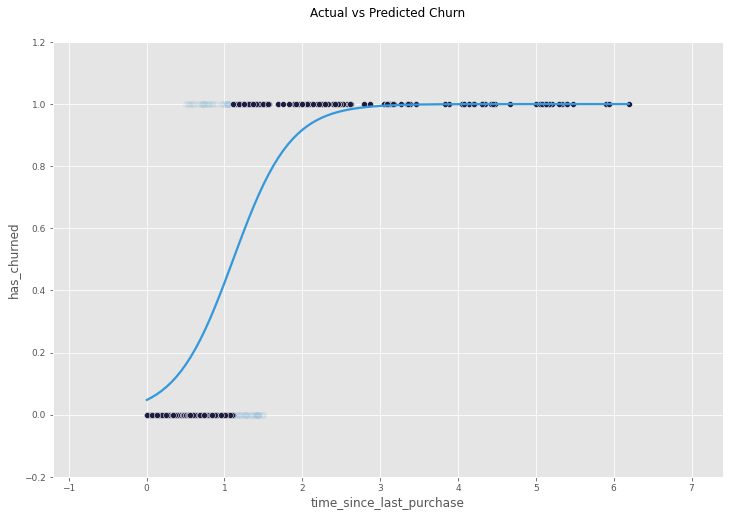

In [7]:
# log reg plot
def viz_reg_log(data, y, x, ax, title):
    sns.regplot(ax=ax, data=data, x=x, y=y, ci=None, logistic=True, color=color[0], scatter_kws={'alpha':0.025})
    ax.set_xlim(round(min(data[x]) - (max(data[x])/5),1), round(max(data[x]) + (max(data[x])/5),1))
    ax.set_ylim(round(min(data[y]) - (max(data[y])/5),1), round(max(data[y]) + (max(data[y])/5),1))   
    ax.set_title(title)
    return ax

# viz scatter
def viz_scatter(data, y, x, ax):
    sns.scatterplot(data=data, y=y, x=x, ax=ax, color=color[1])
    ax.set_xlim(round(min(data[x]) - (max(data[x])/5),1), round(max(data[x]) + (max(data[x])/5),1))
    ax.set_ylim(round(min(data[y]) - (max(data[y])/5),1), round(max(data[y]) + (max(data[y])/5),1))   
    return ax

# fig
fig, ax_1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# viz
viz_reg_log(data, y, x, ax_1, 'Actual vs Predicted Churn')
viz_scatter(data, y_prediction, x, ax_1)

# show
plt.show()

<br>

<h3><font color='grey'>Confusion matrix - how accurate is our model?</font></h3>

<p>A <code>confusion matrix</code> is stored to assess the accuracy of our model by pinpointing the percentage of correct predictions. Since we have actuals (<code>has_churned</code>) and predictions (<code>mdl_prediction_outcome</code>), we can identify <code>False-Positives</code> (how many 0s were incorrectly predicted as 1) and <code>True-Negatives</code> (how many 0s were incorrectly predicted as 1). We use model <code>sensitivity</code> and <code>specificity</code> to describe the accuracy of the 1 and 0 populations, respectively.</p>

<ul>
    <li><code>accuracy</code>: % of correct predictions.</li>
    <li><code>sensitivity</code>: % of actual True population predicted correctly.</li>
    <li><code>specificity</code>: % of actual False population predicted correctly.</li>
</ul>

<br>

           Fit   Score
0     Accuracy  0.7575
1  Sensitivity  0.7350
2  Specificity  0.7800


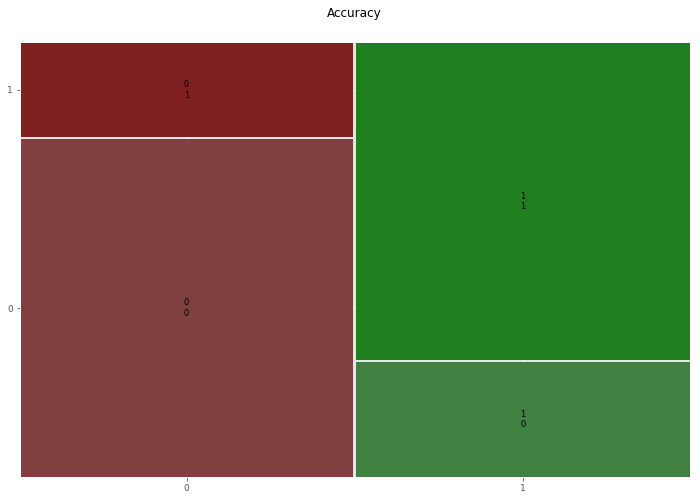

In [8]:
# confusion matrix
mdl_conf_matrix = mdl_output[4]
mdl_fit = mdl_output[5]

# fig
fig, ax_1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# viz
mosaic(mdl_conf_matrix, ax=ax_1, title='Accuracy')

# show
print(mdl_fit)
plt.show()

<hr>

<br>

<h2><font color='#3498DB'>Analysis</font></h2>

<h3><font color='grey'>Making predictions</font></h3>

<ul>
    <li><code>mdl.predict</code>: % chance of churn based on model.</li>
    <li><code>most_likely_outcome</code>: rounds predicted value to 0 or 1.</li>
    <li><code>odds_ratio</code>: probability of churn vs probability of non-churn (<code>prediction/(1-prediction)</code>).</li>
</ul>

<br>

In [9]:
# sample data
df_predictions = pd.DataFrame({'time_since_last_purchase':np.arange(0, 7, 0.25)})

# most liekly outcome
df_predictions['has_churned'] = mdl.predict(df_predictions['time_since_last_purchase'])
df_predictions['most_likely_outcome'] = round(mdl.predict(df_predictions['time_since_last_purchase']))

# odds ratio
df_predictions['odds_ratio'] = df_predictions['has_churned'] / (1 - df_predictions['has_churned'])
df_predictions['odds_ratio_log'] = np.log(df_predictions['odds_ratio'])

# show
df_predictions.head()

,time_since_last_purchase,has_churned,most_likely_outcome,odds_ratio,odds_ratio_log
0,0.00,0.046857,0.0,0.049161,-3.012657
1,0.25,0.088157,0.0,0.096681,-2.336343
2,0.50,0.159758,0.0,0.190133,-1.660030
3,0.75,0.272155,0.0,0.373919,-0.983716
4,1.00,0.423749,0.0,0.735354,-0.307403


<br>

<h3><font color='grey'>The "S-curve"</font></h3>

<p>A <code>confusion matrix</code> is stored to assess the accuracy of our model by pinpointing the percentage of correct predictions. Since we have actuals (<code>has_churned</code>) and predictions (<code>mdl_prediction_outcome</code>), we can identify <code>False-Positives</code> (how many 0s were incorrectly predicted as 1) and <code>True-Negatives</code> (how many 0s were incorrectly predicted as 1). We use model <code>sensitivity</code> and <code>specificity</code> to describe the accuracy of the 1 and 0 populations, respectively.</p>

<br>

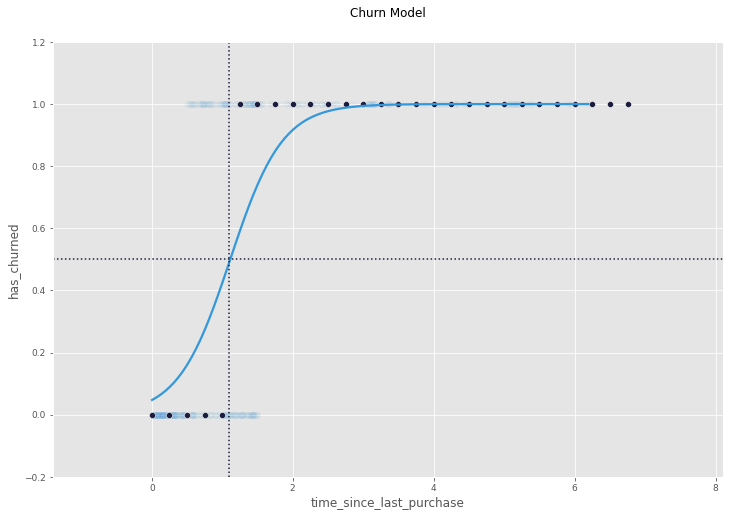

In [10]:
# fig
fig, ax_1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# viz
viz_reg_log(df, 'has_churned', 'time_since_last_purchase', ax_1, 'Churn Model')
viz_scatter(df_predictions, 'most_likely_outcome', 'time_since_last_purchase', ax_1)
ax_1.axvline(x=1.1, linestyle='dotted', color=color[1])
ax_1.axhline(y=0.5, linestyle='dotted', color=color[1])

# show
plt.show()

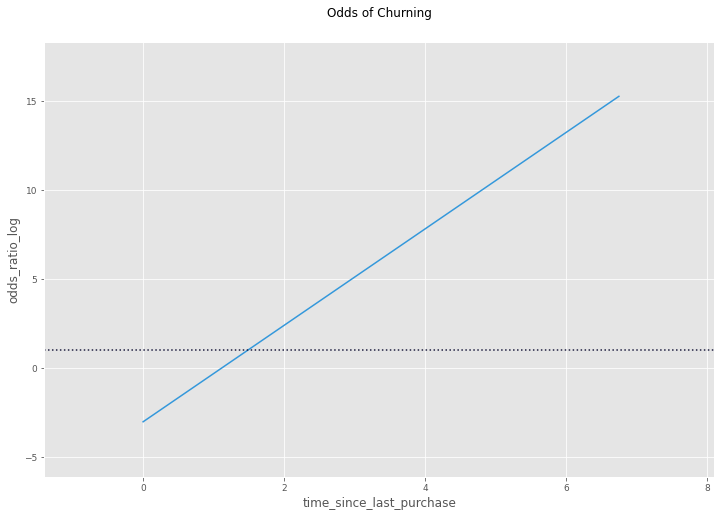

In [11]:
# line plot
def viz_line(data, y, x, ax, title):
    sns.lineplot(data=data, y=y, x=x, ax=ax, color=color[0])
    ax.set_xlim(round(min(data[x]) - (max(data[x])/5),1), round(max(data[x]) + (max(data[x])/5),1))
    ax.set_ylim(round(min(data[y]) - (max(data[y])/5),1), round(max(data[y]) + (max(data[y])/5),1))
    ax.set_title(title)
    return ax

# fig
fig, ax_1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# viz
viz_line(df_predictions, 'odds_ratio_log', 'time_since_last_purchase', ax_1, 'Odds of Churning')
ax_1.axhline(y=1, linestyle='dotted', color=color[1])

# show
plt.show()

<hr>

<br>

<h2><font color='#3498DB'>Conclusions</font></h2>

<h3><font color='grey'>Making predictions</font></h3>

<ul>
    <li><code>mdl.predict</code>: % chance of churn based on model.</li>
    <li><code>most_likely_outcome</code>: rounds predicted value to 0 or 1.</li>
    <li><code>odds_ratio</code>: probability of churn vs probability of non-churn (<code>prediction/(1-prediction)</code>).</li>
</ul>

<br>